# National Park Public Use Data
This notebook is an analysis of data downloaded from the [National Park Visitor Use Statistics](https://irma.nps.gov/STATS/) page. The data used in this notebook was downloaded from the public use statistics available from IRMA on February 3, 2020. 

This notebook is a subset of an attempt to quantify the [issue](https://e360.yale.edu/features/greenlock-a-visitor-crush-is-overwhelming-americas-national-parks) of [overcrowding](https://scholarship.law.nd.edu/cgi/viewcontent.cgi?article=4830&context=ndlr) in National Parks. When Congress created the National Park Service (NPS) in 1916, the agency was tasked with the purpose to [“conserve the scenery and natural and historic objects and the wild life therein and to provide the enjoyment of the same in such manner and by such means as will leave them unimpaired for the enjoyment of future generations.”](https://www.nps.gov/foun/learn/management/upload/1916%20ACT%20TO%20ESTABLISH%20A%20NATIONAL%20PARK%20SERVICE-5.pdf). Unfortunattely, the increasing number of visitors to the parks each year, particularly with regards to the most popular parks, presents an interesting dilemma to the NPS. Is it possible to accommodate an increasing number of visitors to the park while conserving public lands? Are visitor caps to popular parks inevitable, and if so, how can we establish a carrying capacity for each park? Would attempting to disperse traffic to less well-known national parks work and if so, how would we direct it? Most importantly, can we answer these questions with the public datasets that are available? 

Although this notebook only scratches the surface of those questions, it seems important to first quantify how people actually use national parklands first.

Have the number of visitors to national parks changed over time, or is it just the distribution in how people use national parkland? Do most people who visit national parks do so for hiking, camping, scenic drives, or for some other purpose? This notebook looks at a specific subset of camping and recreational use data to find out through analyzing camping data over time.

In [1]:
#import packages
import pandas as pd
import numpy as np
from sklearn import cluster, linear_model
from radar_chart import radar_chart
import matplotlib.pyplot as plt

### Read in the data
First, we want to read in the data from the .csv files. Each dataset has been split into a .csv file by decade. The next cell reads in each of the .csv files and stores them in a pandas dataframe, public_use_data. 

In [2]:
public_use_yrs = ['1979', '1980-1984', '1985-1989', '1990-1994', '1995-1999', 
                    '2000-2004', '2005-2009', '2010-2018']
# Read first .csv to get header names
public_use_data = pd.read_csv('Public Use Statistics 1979.csv', sep=',', 
                              header=2, usecols=list(range(18)), thousands=',')
# Loop through each .csv and store the information in public_use_data
for yr in public_use_yrs[1:]:
    fname = 'Public Use Statistics ' + yr + '.csv'
    df = pd.read_csv(fname, sep=',', header=2, usecols=list(range(18)), 
                     thousands=',')
    public_use_data = pd.concat([public_use_data,df], axis=0)

### Understanding the dataset

Taking a look at the information available in the dataset:

In [11]:
public_use_data.head()

,ParkName,UnitCode,ParkType,Region,State,Year,Month,RecreationVisits,NonRecreationVisits,RecreationHours,NonRecreationHours,ConcessionerLodging,ConcessionerCamping,TentCampers,RVCampers,Backcountry,NonRecreationOvernightStays,MiscellaneousOvernightStays
0,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,1,1586,0,1586,0,0,0,0,0,0,0,0
1,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,2,3036,0,3036,0,0,0,0,0,0,0,0
2,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,3,9853,0,9853,0,0,0,0,0,0,0,0
3,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,4,33087,0,33087,0,0,0,0,0,0,0,0
4,Abraham Lincoln Birthplace NHP,ABLI,National Historical Park,Southeast,KY,1979,5,27838,0,27838,0,0,0,0,0,0,0,0


We can see that the data includes the national park name, unit code, park type, locational information, and then the number of various types of visits for a given month and year. To de-mystify some of the categories, NPS Stats has provided a key to each column header [here](https://www.nps.gov/subjects/socialscience/upload/nps-stats-definitions_accessible1.pdf):

- *RecreationVisits*: "The entry of a person onto lands or waters administered by the NPS except as defined above for non-reportable and non-recreation visits." This is your standard national park visitor, intentionally visiting the park to hike, swim, sightsee, etc. NPS seems to define all camping visits as separate from recreation visits as there are several instances of parks having more camping visitors than recreation visitors, so this category seems to exclude any overnight stays.

- *NonRecreationVisits*: This category includes people commuting through a park, entry by park personnel and tour guides, research visits, and commercial visits.

- *ConcessionerLodging*: Concessioner lodging refers to a category of overnight stays that are outsourced to a private entity and aren't strictly camping, such as "hotels, motels, cabins, cottages, trailer villages, and trailer courts where trailers are available for rent by visitors."

- *ConcessionerCamping*: Concessioner camping involves overnight camping in an RV or tent while on park lands, but where the campground is run by a private entity.

- *TentCampers*: This is a standard car camping visit on a NPS campground, in a tent, for one night.

- *RVCampers*: "One night within a park by a visitor in an RV in an NPS-owned campground."

- *Backcountry*: Backcountry camping is defined as a night at a primitive or wilderness site, typically one that must be reached by hiking (or boat or horseback).

- *MiscellaneousOvernightStays*: "Any overnight stay not otherwise defined such as sleeping aboard boats, camping in organized groups campsites, and/or any overnight stays not included in other categories of overnight stays." 

Looking at the head of the public_use_data doesn't give us a great idea of the parks that are getting the most use. We can group the data by the total number of recreational visits since 1979 to get an idea of the most popular parks:

In [18]:
# Order a dataframe by the most visits over a
most_used_parks = public_use_data.drop(columns=['Year','Month'])
most_used_parks = most_used_parks.groupby(['ParkName','ParkType','Region']).sum()
most_used_parks = most_used_parks.sort_values('RecreationVisits',ascending=False)

# Look at the top 10 parks
most_used_parks.head(n=10)

,,,RecreationVisits,NonRecreationVisits,RecreationHours,NonRecreationHours,ConcessionerLodging,ConcessionerCamping,TentCampers,RVCampers,Backcountry,NonRecreationOvernightStays,MiscellaneousOvernightStays
ParkName,ParkType,Region,,,,,,,,,,,
Blue Ridge PKWY,National Parkway,Southeast,666345062,97726824,4519092066,97726824,2248170,476103,2400150,2469531,135678,0,65409
Golden Gate NRA,National Recreation Area,Pacific West,622576281,415200,1285406937,415200,1813595,0,104774,0,24736,129202,791788
Great Smoky Mountains NP,National Park,Southeast,374610158,380039388,2773976250,380039388,408213,0,7014361,5927053,3295824,0,938764
Gateway NRA,National Recreation Area,Northeast,310321380,25342031,1106591306,25342031,0,0,33161,5655,21485,3500,276985
Lake Mead NRA,National Recreation Area,Pacific West,305485186,11056847,2715916898,11056847,2107464,8086974,4696108,9880386,12255750,8812224,4285223
Natchez Trace PKWY,National Parkway,Southeast,296607431,291773692,1067480059,291773692,0,0,277493,546117,0,0,0
George Washington MEM PKWY,National Parkway,National Capital,285041725,817001100,339740432,817001100,0,0,0,0,0,0,0
Cape Cod NS,National Seashore,Northeast,183973838,1184666,367905655,1184666,192081,0,0,0,0,0,745194
Gulf Islands NS,National Seashore,Southeast,176438988,3355466,632052210,3355466,0,0,1280612,3968179,96046,163343,375441


Surprisingly, the [Blue Ridge Parkway](https://www.nps.gov/blri/index.htm) is the most popular national park(way) in the United States! As someone who grew up in the Blue Ridge Mountains and used the parkway regularly for hiking and scenic drives, this result is somewhat unsurprising. It's a beautiful area, and perhaps it owes its popularity to its length (469 miles), running through Virginia and North Carolina. However, I don't know that it would be my first choice for camping, as it is, predominantly, a road. A number of entries on this list (particularly George Washington Memorial Parkway outside of Washington, D.C.) don't seem particularly suitable for doing much else aside from scenic drives. 

Where would I go if I'm towing an RV? What would be a more suitable park for me if I have a hard time sleeping near the hum of the generators that come with an RV camping? What if I prefer not sleeping outside at all, but want to stay at a national park? Let's break down how visitors tend to use national parks for camping.

## K-Means Clustering Parks By Camping Use

We will attempt to group the parks by the distribution of how people tend to camp in them, i.e. tent camping, backcountry camping, RV camping, or through concessioner lodging. We will only look at data from the last decade (2010-2019).

In [19]:
# subset the public use data into the total usage of all parks from 2010-2019
parks = public_use_data[public_use_data['Year'] >= 2010]
parks = parks.drop(columns=['Year','Month']).groupby(['ParkName']).sum()

We have created a new dataframe, parks, that contains the aggregate park use data for each park from 2010 and on. The cell below will add a new column to parks with the total number of camping visits. We'll then separate out all parks in which no one has camped in the last decade and store it in another dataframe, camping.

In [22]:
# Create new column headers for camping and camping as a percentage of
# all recreational overnight stays
camping_columns = ['ConcessionerLodging','ConcessionerCamping','TentCampers','RVCampers','Backcountry']
camping_columns_percent = [s + 'Percent' for s in camping_columns]

# Get the total number of camping instances in each park
parks['CampingTotal'] = parks[camping_columns].sum(axis=1)

# Create a new subset of parks that only includes parks where the total 
# camping usage is greater than zero.
camping = parks[parks['CampingTotal'] != 0]

How many national parks are included in our dataset? How many parks allow for camping?

In [25]:
# Print the total number of parks, and the numbers that do and don't have recreational camping.
print('Total number of national parks included in analysis (2010-2019): ' +  str(len(parks)))
print('Total number of national parks with recreational camping: ' + str(len(camping)))
print('Total number of national parks with no recreational camping: ' + str(len(parks) - len(camping)))

Total number of national parks included in analysis (2010-2019): 379
Total number of national parks with recreational camping: 134
Total number of national parks with no recreational camping: 245


Right off the bat, we notice that the majority of national parks don't allow for recreational camping. This makes sense, given that the park service oversees things like national monuments and historical sites that aren't really suitable for camping. Let's look within our subset of parks that allow camping to see how often visitors camp there:

In [29]:
# Add a new column to the camping dataframe that gives the percent of visitors who are camping.
camping['PercentVisitorsCamping'] = 100 * camping['CampingTotal'] / (camping['RecreationVisits'] + camping['CampingTotal'])

# Sort by the percentage of visitors camping to see the parks with the fewest campers
camping = camping.sort_values('PercentVisitorsCamping', ascending=True)
print('Parks with the fewest campers (by percentage):')
print(camping['PercentVisitorsCamping'].head())

# Look that the parks with the most campers.
camping = camping.sort_values('PercentVisitorsCamping', ascending=False)
print('\n')
print('Parks with the most campers (by percentage):')
print(camping['PercentVisitorsCamping'].head())

Parks with the fewest campers (by percentage):
ParkName
Wupatki NM                    0.003100
Santa Monica Mountains NRA    0.019562
Carlsbad Caverns NP           0.039426
Kings Mountain NMP            0.042018
Gateway NRA                   0.057683
Name: PercentVisitorsCamping, dtype: float64


Parks with the most campers (by percentage):
ParkName
Rio Grande W&SR               83.641592
Yukon-Charley Rivers NPRES    75.451687
Aniakchak NM & PRES           72.441450
Isle Royale NP                68.284323
North Cascades NP             46.698738
Name: PercentVisitorsCamping, dtype: float64


There's a relatively large variation in parks as far as the relative amount of people who are using them for camping, from < 0.005% of visitors at [Wupatki National Monument](https://www.nps.gov/wupa/index.htm) to over 80% of visitors at [Rio Grande Wild and Scenic River](https://www.nps.gov/rigr/index.htm). Both parks seem to be relatively less traficked, and neither seem to have any type of camping except primative/backcountry.

Let's look at the breakdown of the camping types by adding a column to the camping dataframe for the percentage of each type of camping.

In [30]:
# Append a percentage column for each type of camping.
camping_percent = camping.apply(lambda x:x[camping_columns]/x['CampingTotal'], 
                                axis=1)
camping_percent.columns = [str(col) + 'Percent' for col in camping_percent.columns]
camping = pd.concat([camping,camping_percent], axis=1)

We'll use k-means clustering to group each park based into 4 clusters based the relative concentrations of each type of camping:

Text(0.75, 0.05, 'Lake Mead NRA\nNatchez Trace PKWY\nGulf Islands NS\nGlacier NP\nBryce Canyon NP')

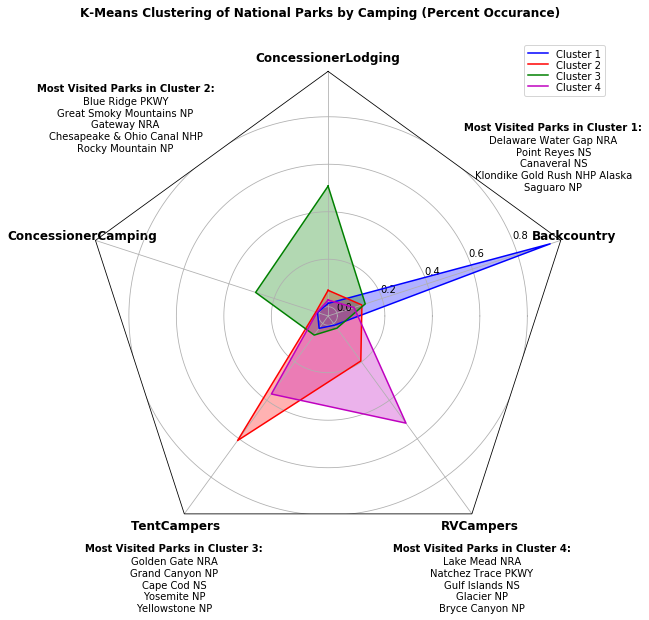

In [33]:
# Cluster the parks based on the percentage of each type of camping.
np_camping = camping[camping_columns_percent].to_numpy()
k_means = cluster.KMeans(n_clusters=4)
k_means.fit(np_camping)

# Get the cluster centroid values
values = pd.DataFrame(k_means.cluster_centers_.squeeze(),
                      columns=camping_columns_percent)

# Plot a spider chart of the cluster centroids
fig, ax = radar_chart(values, camping_columns)
labels = k_means.labels_
camping['Cluster'] = labels

# Figure out the top 10 most visited parks in each cluster.
backcountry_cluster = camping[camping['Cluster'] == 0]
backcountry_cluster = backcountry_cluster.sort_values('RecreationVisits', 
                                                      ascending=False)
backcountry = list(backcountry_cluster.index[0:10])

concessioner_cluster = camping[camping['Cluster'] == 1]
concessioner_cluster = concessioner_cluster.sort_values('RecreationVisits', 
                                                        ascending=False)
concessioner = list(concessioner_cluster.index[0:10])

tent_cluster = camping[camping['Cluster'] == 2]
tent_cluster = tent_cluster.sort_values('RecreationVisits', ascending=False)
tent = list(tent_cluster.index[0:10])

RV_cluster = camping[camping['Cluster'] == 3]
RV_cluster = RV_cluster.sort_values('RecreationVisits', ascending=False)
RV = list(RV_cluster.index[0:10])

# Append the top 5 to the radar chart
fig.text(0.5, 0.965, 'K-Means Clustering of National Parks by Camping (Percent Occurance)',
             horizontalalignment='center', color='black', weight='bold',
             size='large')
newline = '\n'
fig.text(0.86, 0.79, 'Most Visited Parks in Cluster 1:', fontweight='bold', ha='center',
         wrap=True)
fig.text(0.86, 0.7, newline.join(backcountry[0:5]), ha='center', wrap=True)
fig.text(0.2, 0.85, 'Most Visited Parks in Cluster 2:', fontweight='bold', ha='center',
         wrap=True)
fig.text(0.2, 0.76, newline.join(concessioner[0:5]), ha='center', wrap=True)
fig.text(0.275, 0.14, 'Most Visited Parks in Cluster 3:', fontweight='bold', ha='center',
         wrap=True)
fig.text(0.275, 0.05, newline.join(tent[0:5]), ha='center', wrap=True)
fig.text(0.75, 0.14, 'Most Visited Parks in Cluster 4:', fontweight='bold', ha='center',
         wrap=True)
fig.text(0.75, 0.05, newline.join(RV[0:5]), ha='center', wrap=True)

One cluster jumps out immediately, which are parks that are primarily or exclusively used for backcountry camping. Parks in this cluster (Delaware Water Gap, Point Reyes National Seashore, Saguaro National Park, etc) seem best for the curmudgeons of the camping world: people who go camping to be alone in nature and don't want to see other people. These parks seem best for people who are willing to hike out to get away from the crowds. 

Another cluster is primarily centered around concessioner lodging and camping. Parks in these clusters (Golden Gate National Recreation Area, Grand Canyon National Park, Yosemite National Park, etc) tend to be the more popular national parks that get a lot of visitors each year and have outsourced camping and lodging to private commercial ventures. Parks in this cluster seem to be the best bet for people looking for cabins, hotels, or even just a reliable campground that may be more responsive to customer demands than your average national park service campground.

The last two clusters have quite a bit of overlap, but still seem to maintain a division based on the relative ratios of tent campers vs RV campers. The national park service tends to operate more campgrounds and RV lots in these parks. People with an RV in tow may have an easier time finding a parking spot at Lake Mead National Recreation Area, Natchez Trace Parkway, or Glacier National Park, while car campers seem to trend more towards the Blue Ridge Parkway, Great Smoky Mountains National Park, or Gateway National Recreation Area.

## Linear Regression of Recreational Visitor and Camping Trends

There do appear to be distinctly different ways that visitors can camp in national parks, but has there been any evolution in how this usage has changed over time? Let's look at general park usage and recreational camping usage since 1979 to look for any long-term trends.

We'll create another subset dataframe, parks_by_year, with additional columns that give the total visits in all national parks, including non-recreational and miscellaneous usage, and the total number of camping visits.

In [34]:
# Subset the public use data, group by year.
parks_by_year = public_use_data.drop(columns=['Month']).groupby('Year').sum()

# Add columns for the total usage
parks_by_year['CampingTotal'] = parks_by_year[camping_columns].sum(axis=1)
parks_by_year['TotalVisits'] = parks_by_year['CampingTotal'] + parks_by_year['RecreationVisits'] + parks_by_year['NonRecreationVisits'] + parks_by_year['NonRecreationOvernightStays'] + parks_by_year['MiscellaneousOvernightStays']
parks_by_year['TotalRecreationVisits'] = parks_by_year['CampingTotal'] + parks_by_year['RecreationVisits']

In [35]:
# Append a percentage column for each type of camping.
camping_percent_by_year = parks_by_year.apply(lambda x:x[camping_columns]/x['CampingTotal'], 
                                axis=1)
camping_percent_by_year.columns = [str(col) + 'Percent' for col in camping_percent_by_year.columns]
parks_by_year = pd.concat([parks_by_year,camping_percent_by_year], axis=1)

Let's run a simple linear regression on the total number of visits to national parks to see trends over time.

In [36]:
# Fit a trendline to the data to predict the total number of visits to each
# national park in 2020.     
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using year as X and recreational visitors per year
X = parks_by_year.index.values.reshape(-1,1)
Y = parks_by_year['TotalVisits'].values.reshape(-1,1)
regr.fit(X, Y)

# Make predictions using the testing set
visitors_trendline = np.linspace(start=1979, stop=2030, num=2030-1979+1)
visitors_prediction = regr.predict(visitors_trendline.reshape(-1,1))

We'll also run a linear regression on the total number of camping visits over time:

In [37]:
# Create linear regression object
regr_camp = linear_model.LinearRegression()

# Train the model using total number of campers per year
# Use the same X input (year)
Y = parks_by_year['CampingTotal'].values.reshape(-1,1)
regr_camp.fit(X, Y)

# Make predictions using the testing set
campers_trendline = np.linspace(start=1979, stop=2030, num=2030-1979+1)
campers_prediction = regr_camp.predict(campers_trendline.reshape(-1,1))

The cell below will plot the total number of visitors and campers over time with their respective trendlines.

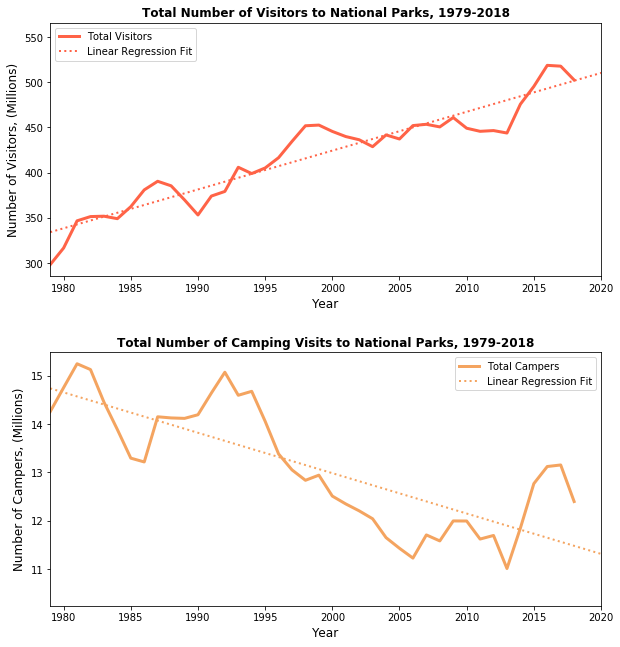

In [38]:
# Plot the predictions for number of visitors and number of campers
fig1, axs1 = plt.subplots(figsize=(9, 9), nrows=2, ncols=1, 
                        gridspec_kw = {'hspace':0.3, 'wspace':0, 'top':0.95, 
                                       'left':0.1, 'right':0.95, 
                                       'bottom':0.05})
axs1[0].plot(parks_by_year.index.values, parks_by_year['TotalVisits']/1E6,
    linewidth=3, linestyle='-', color='tomato') 
axs1[0].plot(visitors_trendline, visitors_prediction/1E6, linewidth=2, 
    linestyle=':', color='tomato')
axs1[0].set_ylabel('Number of Visitors, (Millions)', fontsize=12)
axs1[0].set_xlabel('Year', fontsize=12)
axs1[0].set_title('Total Number of Visitors to National Parks, 1979-2018', 
   fontweight='bold')
axs1[0].set_xlim([1979,2020])
axs1[0].legend(labels=['Total Visitors', 
   'Linear Regression Fit'], loc='upper left')
    
axs1[1].plot(parks_by_year.index.values, parks_by_year['CampingTotal']/1E6,
    linewidth=3, linestyle='-', color='sandybrown') 
axs1[1].plot(campers_trendline, campers_prediction/1E6, linewidth=2, 
    linestyle=':', color='sandybrown')
axs1[1].set_ylabel('Number of Campers, (Millions)', fontsize=12)
axs1[1].set_xlabel('Year', fontsize=12)
axs1[1].set_title('Total Number of Camping Visits to National Parks, 1979-2018', 
   fontweight='bold')
axs1[1].set_xlim([1979,2020])
axs1[1].legend(labels=['Total Campers', 
   'Linear Regression Fit'], loc='upper right')

There are pretty clear trends in the vistor and camping data: The overall number of visitors to national parks is increasing every year, while the total number of people camping on national parkland is actually *decreasing*. 

We can breakdown the relative composition of both the total visitors to the park and the number of campers over time with a stack plot.

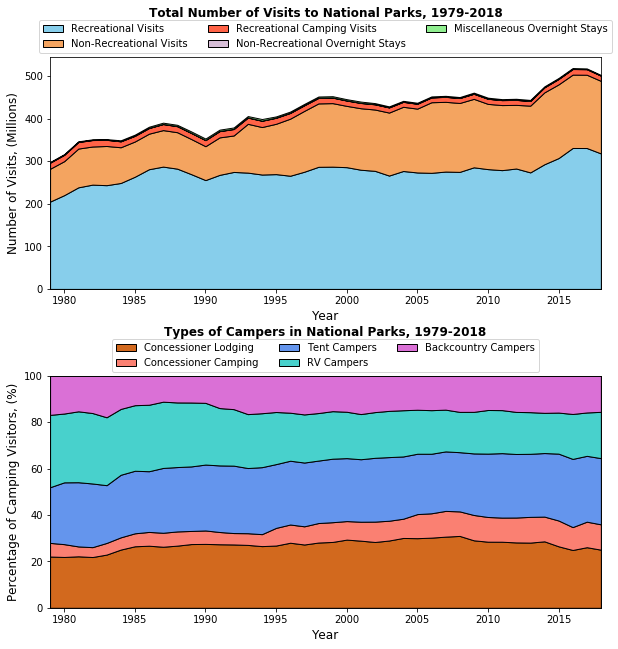

In [39]:
# Plot the total number of visits per year over time
fig, axs = plt.subplots(figsize=(9, 9), nrows=2, ncols=1, 
                        gridspec_kw = {'hspace':0.375, 'wspace':0, 'top':0.9, 
                                       'left':0.1, 'right':0.95, 
                                       'bottom':0.05})

# Plot overall recreation visits by year
labels = ['Recreational Visits', 'Non-Recreational Visits', 
          'Recreational Camping Visits', 'Non-Recreational Overnight Stays', 
          'Miscellaneous Overnight Stays']
colors = ['skyblue', 'sandybrown', 'tomato', 'thistle', 'lightgreen']
y = np.vstack([parks_by_year['RecreationVisits'], 
               parks_by_year['NonRecreationVisits'], 
               parks_by_year['CampingTotal'],
               parks_by_year['NonRecreationOvernightStays'],
               parks_by_year['MiscellaneousOvernightStays']])
y = y/1E6
axs[0].stackplot(parks_by_year.index.values, y, labels=labels, colors=colors, 
                   edgecolor='black')
axs[0].set_ylabel('Number of Visits, (Millions)', fontsize=12)
axs[0].set_xlabel('Year', fontsize=12)
axs[0].set_title('Total Number of Visits to National Parks, 1979-2018', 
   fontweight='bold', pad=40)
axs[0].set_xlim([1979,2018])
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)

# Plot a breakdown of camping types by year
labels = ['Concessioner Lodging', 'Concessioner Camping', 'Tent Campers', 
          'RV Campers', 'Backcountry Campers']
colors = ['chocolate', 'salmon', 'cornflowerblue', 'mediumturquoise', 'orchid']
y = np.vstack([parks_by_year[camping_columns_percent]])
y = y*100
axs[1].stackplot(parks_by_year.index.values, np.transpose(y), labels=labels,
   colors=colors, edgecolor='black')
axs[1].set_ylabel('Percentage of Camping Visitors, (%)', fontsize=12)
axs[1].set_xlabel('Year', fontsize=12)
axs[1].set_title('Types of Campers in National Parks, 1979-2018', 
   fontweight='bold', pad=40)
axs[1].set_xlim([1979,2018])
axs[1].set_ylim([0,100])
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3)

We can see that the total visits to the park is increasing, which is largely driven by the increase in both recreational and non-recreational visitors. Miscellaneous overnight stays and non-recreational overnight stays represent a very small fraction of the total number of visits. We can see that campers also represent a pretty small chunk of overall national park visitors.

If we breakdown the types of camping, the relative portion of concessioner lodging is relatively stable over time, while concessioner camping is growing overall from 1979. This trend may be interesting to look at in the context of the privitization of our national parks, particularly in relation to public spending in national parks. Interestingly, the decrease in overall camping seems to be largely driven by a decrease in RV campers, from about 30% of all campers in 1979 to less than 20% in 2018. Backcountry and tent camping appear to be relatively stable over time.


## Conclusions and Future Work

America's national parks are iconic, and their popularity as a tourist destination is increasing. Fewer and fewer people chose to stay overnight within them, however. It is unclear what the driving factor is behind this trend, although the decline in the popularity of RV camping overall may be a factor. There are clear groupings in the way people tend to camp in national parks, in which some parks direct visitors towards the privitized campgrounds and lodging, some that are more favorable for tent campers or RV campers, and some that require primative camping.

The NPS publishes a number of datasets, including information about traffic use of national parks and GIS data of boundaries and points of interest. Future work will involve looking at the density of visitors to the parks, and whether we can quantify the density of visitors in individual parks through traffic data. 

Another interesting aspect of National Park usage to look at would be the its relation to the budget. The NPS generates revenue through [fees](https://www.nps.gov/orgs/1207/10-24-2017-fee-changes-proposal.htm) and permits rather than solely relying on federal funding. As all data on US goverment spending is available through [usaspending.gov](https://www.usaspending.gov/), a good point of analysis would be the relationship of funding increases and decreases and how they pertain to certain aspects of overcrowding.